<a href="https://colab.research.google.com/github/gsankarvg/colab-projects/blob/main/Brain_Tumor_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Data source import complete.


In [2]:
!pip install torch torchvision matplotlib

In [3]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
tf = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dl = DataLoader(
    datasets.ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Training', tf),
    batch_size = 32, shuffle = True, num_workers = 4, pin_memory = True
)


test_dl = DataLoader(
    datasets.ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Testing', tf),
    batch_size = 32, shuffle = False, num_workers = 4, pin_memory = True
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
model = nn.Sequential(
    nn.Conv2d(3,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(32,64,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(64,128,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128 * 16 * 16, 256), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(256,4) # 4 classes
). to(device)

In [7]:
opt = optim.AdamW(model.parameters(), 1e-4)
loss_fn = nn.CrossEntropyLoss()

In [8]:
model.train()

for epoch in range(25):
    running_loss = 0

    for x, y in train_dl:
        opt.zero_grad()

        preds = model(x.to(device))
        loss = loss_fn(preds, y.to(device))

        loss.backward()

        running_loss += loss.item()

        opt.step()
    print(f"Epoch {epoch + 1}: Loss was {running_loss}")

Epoch 1: Loss was 147.0885112285614
Epoch 2: Loss was 95.2735525071621
Epoch 3: Loss was 78.73810583353043
Epoch 4: Loss was 68.42428061366081
Epoch 5: Loss was 60.89918965101242
Epoch 6: Loss was 55.64699390530586
Epoch 7: Loss was 47.29706880450249
Epoch 8: Loss was 43.00429018586874
Epoch 9: Loss was 37.54503379762173
Epoch 10: Loss was 34.48972193337977
Epoch 11: Loss was 31.80130121856928
Epoch 12: Loss was 27.239345256239176
Epoch 13: Loss was 23.057999830693007
Epoch 14: Loss was 22.122638676315546
Epoch 15: Loss was 19.502844189293683
Epoch 16: Loss was 18.087187947705388
Epoch 17: Loss was 15.394645830616355
Epoch 18: Loss was 13.99049034062773
Epoch 19: Loss was 12.060032493900508
Epoch 20: Loss was 11.258356132078916
Epoch 21: Loss was 10.799271509516984
Epoch 22: Loss was 9.54613464185968
Epoch 23: Loss was 8.020374970510602
Epoch 24: Loss was 7.75523750949651
Epoch 25: Loss was 6.880430322140455


In [9]:
model.eval()
test_loss, correct = 0.0, 0

with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        test_loss += loss_fn(logits, y).item() * y.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()

test_loss /= len(test_dl.dataset)
accuracy = 100.0 * correct / len(test_dl.dataset)

print('Test Loss:', test_loss, 'Test accuracy', accuracy)

Test Loss: 0.1328402583689105 Test accuracy 96.186117467582


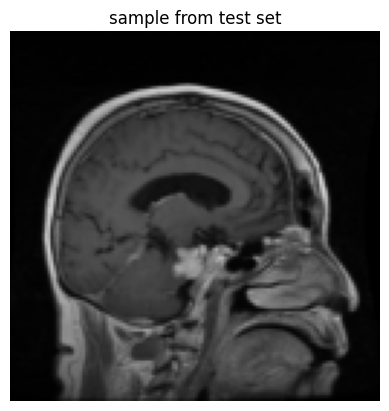

predicted class: meningioma
Ground-truth: meningioma


In [11]:
import random
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

model.eval()
idx = random.randrange(len(test_dl.dataset))
img, label = test_dl.dataset[idx]

unnorm = img * 0.5 + 0.5
plt.imshow(to_pil_image(unnorm))
plt.axis('off')
plt.title('sample from test set')
plt.show()

with torch.no_grad():
    logits = model(img.unsqueeze(0).to(device))
    pred = logits.argmax(1).item()

class_names = test_dl.dataset.classes
print(f"predicted class: {class_names[pred]}")
print(f"Ground-truth: {class_names[label]}")